# Data Science Project - Final Report

## Introduction
This report is a group project in the DSCI 100 course at UBC. For the project we were given two real datasets from a research group at UBC who are interested in understanding how people play videogames. To do the research, they drift a server running the game MineCraft and record sessions of players. The research group wants to manage its server resources according to the demands, and they want to recruit more players to collect data on. In order to recruit more players, the stakeholder want to know which "kinds" of players are most likely to contribute a large amount of data, so that they can be targeted in the recruiting efforts. To help them with this, we have stated the following question below to do analysis on.

---

### Question

**What are the kinds of players, according to "experience", "gender" and "age", are most likely to be a "contributor"of a large amount of data of one hour or more?**

---

## Data Description
We were given two datasets: "Players" and "Sessions". The Players dataset has one row for each induvidual player. The Sessions dataset has one row for each played session. One player can be part of several sessions. Due to the choice of explanatory and response variables in our questions, we only need to use the Players dataset.

#### Players Dataset:
196 observations, 9 variables

- `experience` (chr): Gaming experience of the player                      
- `subscribe`(lgl): Whether the player has subscribed or not            
- `hashedEmail`(chr): Encrypted 64-character hashcode of player's email ID
- `played_hours`(dbl): Number of hours an individual player played         
- `name`(chr): Name of the player                                  
- `gender`(chr): Gender of the player                                
- `age`(dbl): Age of the player                                   
- `individualId`(lgl): ID of the player (empty for all examples)                                    
- `organizationName`(lgl): Organization to which the player belongs (empty for all examples)


## Methods & Results

In this section we will load the dataset, wrangle it to a tidy format and perform our analysis. We will reason the steps taken along the way.

In [41]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [42]:
# Reading data
players_data <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
players_data

# Setting seed for reproducibility
set.seed(123)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


### Why One hour is chosen as the cutoff?

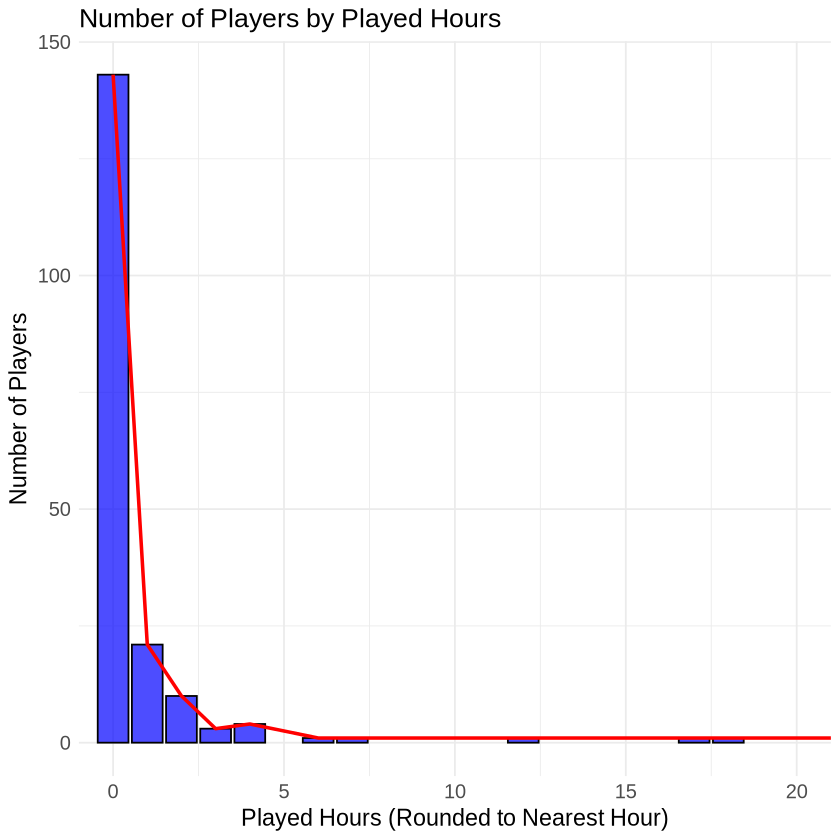

In [23]:
hourly_data <- players_data |>
  mutate(rounded_hours = round(played_hours)) |>
  group_by(rounded_hours) |>
  summarise(number_of_players = n())

ggplot(hourly_data, aes(x = rounded_hours, y = number_of_players)) +
  geom_bar(stat = "identity", fill = "blue", color = "black", alpha = 0.7) +
  geom_line(aes(x = rounded_hours, y = number_of_players), color = "red", size = 1) + 
  labs(title = "Number of Players by Played Hours",
       x = "Played Hours (Rounded to Nearest Hour)",
       y = "Number of Players") +
  coord_cartesian(xlim = c(0, 20)) +
  theme_minimal() +
  theme(plot.title = element_text(size = 16),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

From the graph, we see that majority of players have played for fewer than one hour. This is evident from the bar chart, where the count of players between hour 0 and hour 1 significantly outweighs the counts in subsequent hours.

Therefore, the cutoff is based on a clear observation of the distribution. By analyzing the bar chart, we can see that the frequency drops sharply after 1 hour, indicating a distinct shift in players' behavior/action. We can infer that players who exceed this threshold are likely to be more committed or regular users, and thus will contribute to the large amount of data.

This decision helps to create logical and interpretable groups such as contributors and non-contributors for analysis or intervention.

### Wrangling
We subtract the explanatory features stated in our question: `experience`, `gender` and `age`. Their datatypes are changed to better represent the values of the features: `contributer` and `experience`consists of a limited amount of categories and `age` is limited to being a whole number. The response variable`contributer` are made based on the amount of played hours. The data is still on a tidy format, where each row represents an individual player.

We created a new column named `age_range` from the `age` column to identify patterns across different age groups. The`age_range`column will have five subcategories: 0–18, 19–30, 31–45, 46–60, and 60+. This will help in recognizing any patterns based on age.

In [43]:
# Wrangling data
wrangled_players_data <- players_data |>
  mutate(
    contributor = factor(if_else(played_hours >= 0.2, "Yes", "No")),
    experience = as.factor(experience),
    gender = as.factor(gender),
    age = as.integer(age)
  ) |>
  select(experience, gender, age, contributor)
wrangled_players_data


experience,gender,age,contributor
<fct>,<fct>,<int>,<fct>
Pro,Male,9,Yes
Veteran,Male,17,Yes
Veteran,Male,17,No
⋮,⋮,⋮,⋮
Amateur,Prefer not to say,17,No
Amateur,Male,17,Yes
Pro,Other,91,Yes


### Summarizations and visualizations
For `experience` and `gender` we count the number of players in each category as this gives an intuition for the distrubution of the players. For `age`we see that most players are around 19- 21, but that there are a few outliers that can affect our analysis.

In [44]:
# Summarizing data

#distribution of exprience
wrangled_players_data |>
  group_by(experience) |>
  summarise(count = n())

# distribution of gender
gender<- wrangled_players_data|>
  count(gender)
print(gender)

# distribution of age
wrangled_players_data |>
  summarise(
    min_age = min(age),
    max_age = max(age),
    mean_age = mean(age),
    median_age = median(age)
  )
# distribution of age range
wrangled_players_data |>
group_by(age_range) |>
summarise(count= n())

# proportion of contributor vs. non-contributors
wrangled_players_data |>
  count(contributor) |>
  mutate(proportion = n / sum(n))

experience,count
<fct>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


# A tibble: 7 × 2
  gender                n
  <fct>             <int>
1 Agender               2
2 Female               37
3 Male                124
4 Non-binary           15
5 Other                 1
6 Prefer not to say    11
7 Two-Spirited          6


min_age,max_age,mean_age,median_age
<int>,<int>,<dbl>,<dbl>
8,99,21.28061,19


ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31m✖[39m Column `age_range` is not found.


In [ ]:
# Visualizing data

ggplot(wrangled_players_data, aes(x = experience, fill = factor(contributor))) +
    geom_bar(position = "stack") +
    labs(
        title = "Number of Contributors by Experience",
        x = "Experience",
        y = "Count",
        fill = "Contributor",
        caption = "(Figure 1)"
    ) + 
    theme(text = element_text(size = 15))

ggplot(wrangled_players_data, aes(x = gender, fill = factor(contributor))) +
    geom_bar(position = "fill") +
    labs(
        title = "Proportion of Contributors by Gender",
        x = "Gender",
        y = "Proportion",
        fill = "Contributor",
        caption = ("Figure 2")
    ) + 
    theme(text = element_text(size = 15),
         axis.text.x = element_text(angle = 45, hjust = 1))
### I think going with "count" proves why we need to exclude gender in our analysis

ggplot(wrangled_players_data, aes(x = gender, fill = factor(contributor))) +
    geom_bar(position = "stack") +
    labs(
        title = "Number of Contributors by Gender",
        x = "Gender",
        y = "Count",
        fill = "Contributor",
        caption = "(Figure 2)"
    ) + 
    theme(text = element_text(size = 15))

### DID THE PLOT WITH COUNT AND PROPORTION TO SEE ANY PATTERN
ggplot(wrangled_players_data, aes(x = age_range, fill = factor(contributor))) +
    geom_bar(position = "fill") +
    labs(
        title = "Proportion of Contributors by Age Range",
        x = "Age Range ",
        y = "Proportion",
        fill = "Contributor",
        caption = ("Figure 3")
    ) + 
    theme(text = element_text(size = 15),
         axis.text.x = element_text(angle = 45, hjust = 1))
ggplot(wrangled_players_data, aes(x = age_range, fill = factor(contributor))) +
    geom_bar(position = "stack") +
    labs(
        title = "Number of Contributors by age_range",
        x = "Age Range of players",
        y = "Count",
        fill = "Contributor",
        caption = "(Figure 3)"
    ) + 
    theme(text = element_text(size = 15))

ggplot(wrangled_players_data, aes(x = factor(contributor), y = age, fill = factor(contributor))) +
    geom_boxplot(alpha = 0.7, outlier.size = 2, outlier.color = "red") +
    geom_jitter(width = 0.2, size = 1.5, alpha = 0.6, color = "black") +
    labs(
        title = "Age Distribution of Players",
        x = "Contributor",
        y = "Age of the Player",
        fill = "Contributor Status",
        caption = ("Figure 4")
    ) + 
    theme(text = element_text(size = 15))

ggplot(wrangled_players_data, aes(x = factor(contributor), fill = factor(contributor))) +
    geom_bar(position = "stack", alpha = 0.8) +
    facet_grid(gender ~ experience) +
    labs(
        title = "Contributors by Experience, Gender, and Status",
        x = "Contributor Status (0 = No, 1 = Yes)",
        y = "Count",
        fill = "Contributor Status",
        caption = ("Figure 5")
    ) + 
    theme(text = element_text(size = 15))

### REASON WE NEED TO EXCLUDE GENDER COLUMN IN OUR ANALYSIS
The gender column shows a highly imbalanced distribution:

The "Male" category dominates the dataset with 124 observations, followed by "Female" with 37.
Other categories, such as "Agender," "Other," and "Two-Spirited," have very small counts (e.g., 1–15), making it challenging to draw meaningful conclusions about these groups.
In addition, this might lead to biased interpretations especially if the small groups do not provide statistically significant insights.

### Data analysis
- 75% of the wrangled dataset is used for model training, and the remaining 25% for testing.
- The levels in the `experience`variable is replaced by numbers from 1-5 in order to scale and centre both the explanatory variables.
- Since the stated question is a binary classification problem, the KNN model is used to predict new data.

In [45]:
# DELETE THIS PLOT BEFORE DELIVERY - is here to visualize the change of experience variable into numerical
# plot <- wrangled_players_data |>
#     ggplot(aes(x=age, y=experience, color = contributor)) +
#     geom_point()
# plot

#This wrangling can be done earlier, is used to change wrangled_players_data into only numerical explanatory variables for scaling
numerical_players_data <- wrangled_players_data |>
    select(experience, age, contributor) |> #Do this at earlier stage when we decide to exclude gender
    mutate(experience = as.numeric(factor(experience, levels = c("Amateur", "Beginner", "Pro", "Regualar", "Veteran")))) |> 
    filter(!is.na(experience)) 

# DELETE THIS PLOT BEFORE DELIVERY - is here to visualize the change of experience variable into numerical
# plot_2 <- wrangled_players_data |>
#     ggplot(aes(x=age, y=experience, color = factor(contributor))) +
#     geom_point()
# plot_2

# Splitting Data 75/25
players_split <- initial_split(numerical_players_data, prop = 0.75, strata = contributor)
players_train <- training(players_split)
players_test <- testing(players_split)

# Creating recipe
players_recipe <- recipe(contributor ~ experience + age, data = players_train) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors())

# Defining KNN specification
players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

### Tuning the classifier
 - 5-fold cross validation is used to choose the value of the K parameter. This way we have more data to evaulate the model on.
 - The dashed line in Figure 5 shows the best value of K

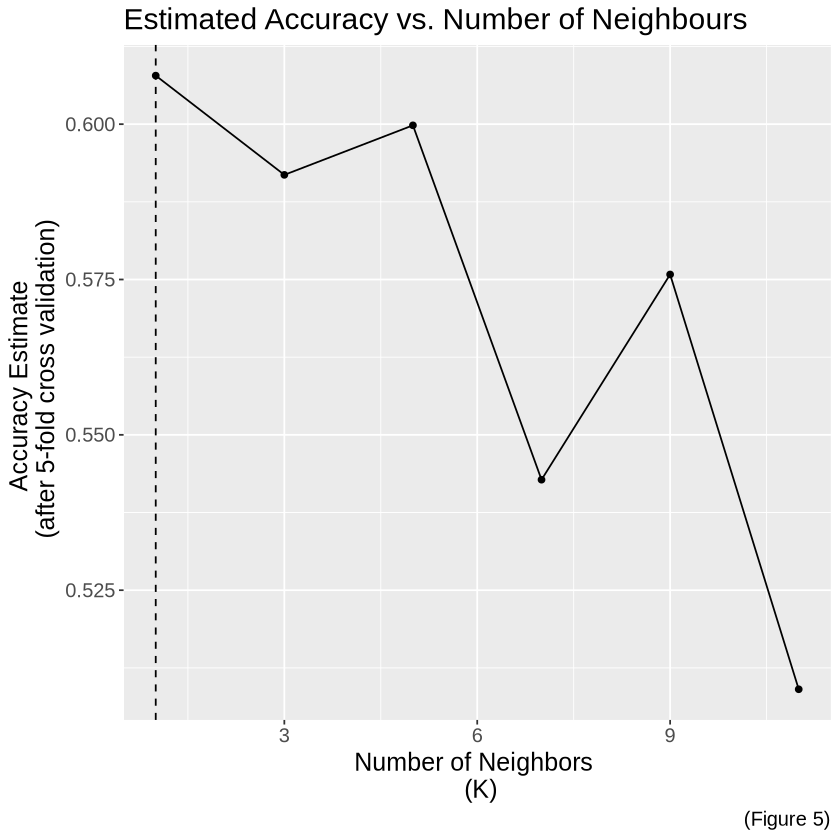

In [46]:
# 5-fold cross validation
players_5_folds <- vfold_cv(players_train, v = 5, strata = contributor)
k_values <- tibble(neighbors = seq(1, 12, by = 2))

# Tuning the model
players_knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_knn_spec) |>
    tune_grid(resamples = players_5_folds, grid = k_values) |>
    collect_metrics()

# Extracting best k from results
accuracies <- players_knn_results |> 
    filter(.metric == "accuracy")

#Choose the k that has the highest accuracy
best_k <- accuracies |> 
    arrange(desc(mean)) |> 
    head(1) |> 
    pull(neighbors)

#Plot accuracy vs k-value
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors \n (K)",
         y = "Accuracy Estimate \n (after 5-fold cross validation)",
         title = "Estimated Accuracy vs. Number of Neighbours",
        caption = "(Figure 5)") +
    theme(text = element_text(size = 15)) + 
    geom_vline(xintercept = best_k, linetype = "dashed")

accuracy_vs_k

### Evaluate on test set
 - Using the defined parameters, the tuned model is again fitted on the whole training data
 - Since the training dat

.pred_class,experience,age,contributor
<fct>,<dbl>,<int>,<fct>
Yes,3,9,Yes
No,5,17,Yes
No,5,17,No
⋮,⋮,⋮,⋮
No,2,17,Yes
No,1,17,Yes
Yes,1,24,Yes


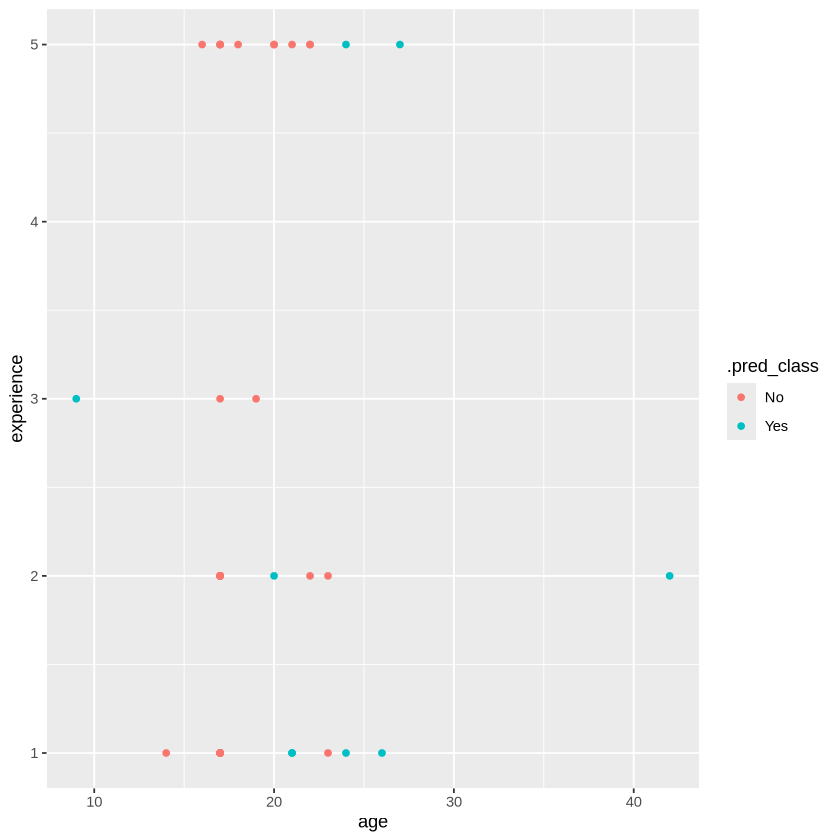

In [47]:
# Define KNN specification with best k
final_knn_spec <- finalize_model(players_knn_spec, tibble(neighbors = best_k))

# Creating workflow with final specification
knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(final_knn_spec) |>
    fit(players_train)

# Apply standardization to test data for plotting os testing?
scaled_test_data <- players_test |>
    mutate(
        age = scale(age),
        experience = scale(experience)
    )

# Making predictions on the testing data
test_predictions <- predict(knn_fit, new_data = players_test) |>
    bind_cols(players_test)
test_predictions

#Visualization of the result
prediction_plot <- test_predictions |>
    ggplot(aes(x=age, y=experience, color=contributor + )) +
    geom_point()

prediction_plot

In [48]:
# Evaluate test metrics
test_results <- test_predictions |>
    mutate(correctness = if_else(contributor == .pred_class, "Correct", "Incorrect"))
cat("Final test result: \n")
test_results

cat("\n")

test_accuracy <- test_results |>
  summarise(accuracy = mean(correctness == "Correct")) |>
  pull(accuracy)

cat("The accuracy of the test result is:", test_accuracy, "\n")
cat("Best k:", best_k, "\n")

# Calculate accuracy
accuracy_result <- test_predictions |>
  metrics(truth = contributor, estimate = .pred_class) |>
  filter(.metric == "accuracy")
cat("\nAccuracy:\n")
print(accuracy_result)

cat("\n")

# Calculate precision
precision_result <- test_predictions |>
  precision(truth = contributor, estimate = .pred_class)
cat("\nPrecision:\n")
print(precision_result)

cat("\n")

# Calculating recall
recall_result <- test_predictions |>
  recall(truth = contributor, estimate = .pred_class)
cat("\nRecall:\n")
print(recall_result)

cat("\n")

# Confusion matrix
confusion_matrix <- test_predictions |>
  conf_mat(truth = contributor, estimate = .pred_class)
cat("\nConfusion Matrix:\n")
print(confusion_matrix)

Final test result: 


.pred_class,experience,age,contributor,correctness
<fct>,<dbl>,<int>,<fct>,<chr>
Yes,3,9,Yes,Correct
No,5,17,Yes,Incorrect
No,5,17,No,Correct
⋮,⋮,⋮,⋮,⋮
No,2,17,Yes,Incorrect
No,1,17,Yes,Incorrect
Yes,1,24,Yes,Correct



The accuracy of the test result is: 0.575 
Best k: 1 

Accuracy:
# A tibble: 1 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.575


Precision:
# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.613


Recall:
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary         0.792


Confusion Matrix:
          Truth
Prediction No Yes
       No  19  12
       Yes  5   4


## **Discussion:** gg

## **References:**

- https://www.geeksforgeeks.org/box-plot-in-r-using-ggplot2/
- https://www.geeksforgeeks.org/how-to-plot-3d-scatter-diagram-using-ggplot-in-r/
- https://recipes.tidymodels.org/articles/Simple_Example.html